In [51]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegressionCV
import numpy as np
import scipy as sp
from scipy.ndimage import filters
import os
os.sys.path.append('../')

import utilities as u
import preprocessing as pp
from functools import reduce
import pickle
import matplotlib.gridspec as gridspec

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
df = pp.load_session_db()
df = df[df['RewardCount']>30]
df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])
tracks = 'TwoTower_noTimeout|TwoTower_Timeout|Reversal_noTimeout|Reversal|TwoTower_foraging|FreqMorph_Decision|FreqMorph_Timeout'
df = df[df['Track'].str.contains(tracks,regex=True)]

G:\My Drive\VR_Data\TwoTower\behavior.sqlite
G:\My Drive\VR_Data\TwoTower\4222174.0\30_05_2019\RuningTraining_1.sqlite
file doesn't exist, errors to come!!!


In [145]:
mouse = '4222153.2'
df_mouse = df[df['MouseName'].str.match(mouse)]
df_mouse

,MouseName,DateFolder,SessionNumber,Track,RewardCount,Imaging,ImagingRegion,DateTime,data file,scanfile,scanmat,s2pfolder
1727,4222153.2,08_04_2019,1,TwoTower_foraging,86,1,CA1,2019-04-08,G:\My Drive\VR_Data\TwoTower\4222153.2\08_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222153.2\08_04_2...,G:\My Drive\2P_Data\TwoTower\4222153.2\08_04_2...
1751,4222153.2,10_04_2019,3,TwoTower_foraging,80,1,CA1,2019-04-10,G:\My Drive\VR_Data\TwoTower\4222153.2\10_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222153.2\10_04_2...,G:\My Drive\2P_Data\TwoTower\4222153.2\10_04_2...
1771,4222153.2,12_04_2019,2,TwoTower_foraging,86,1,CA1,2019-04-12,G:\My Drive\VR_Data\TwoTower\4222153.2\12_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222153.2\12_04_2...,G:\My Drive\2P_Data\TwoTower\4222153.2\12_04_2...
1788,4222153.2,14_04_2019,2,TwoTower_foraging,96,1,CA1,2019-04-14,G:\My Drive\VR_Data\TwoTower\4222153.2\14_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222153.2\14_04_2...,G:\My Drive\2P_Data\TwoTower\4222153.2\14_04_2...
1800,4222153.2,15_04_2019,2,TwoTower_foraging,103,1,CA1,2019-04-15,G:\My Drive\VR_Data\TwoTower\4222153.2\15_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222153.2\15_04_2...,G:\My Drive\2P_Data\TwoTower\4222153.2\15_04_2...
1816,4222153.2,16_04_2019,2,TwoTower_foraging,98,1,CA1,2019-04-16,G:\My Drive\VR_Data\TwoTower\4222153.2\16_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222153.2\16_04_2...,G:\My Drive\2P_Data\TwoTower\4222153.2\16_04_2...
1825,4222153.2,17_04_2019,2,TwoTower_foraging,77,1,CA1,2019-04-17,G:\My Drive\VR_Data\TwoTower\4222153.2\17_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222153.2\17_04_2...,G:\My Drive\2P_Data\TwoTower\4222153.2\17_04_2...
1833,4222153.2,18_04_2019,3,TwoTower_foraging,70,1,CA1,2019-04-18,G:\My Drive\VR_Data\TwoTower\4222153.2\18_04_2...,None,G:\My Drive\2P_Data\TwoTower\4222153.2\18_04_2...,G:\My Drive\2P_Data\TwoTower\4222153.2\18_04_2...


In [146]:
sess = df_mouse.iloc[5]

In [147]:
VRDat,C, S, A = pp.load_scan_sess(sess)
C/=1546

num aberrant ttls 0.0
33545 (33545,) (33545, 21) 121243


C:\Users\mplitt\Anaconda3\lib\site-packages\pandas\core\frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


frame diff 0


In [148]:
pos_mask = VRDat.pos._values>=0
bin_edges= np.arange(0,451,20)
bin_edges[-1]=455
nbins = bin_edges.shape[0]-1
    
train_mask = pos_mask & ((VRDat.morph==1) | (VRDat.morph==0.))


In [149]:
trial_info, tstart_inds, teleport_inds = u.by_trial_info(VRDat)
effmorph =trial_info['morphs']+trial_info['bckgndJitter']+trial_info['wallJitter']+trial_info['towerJitter']
effmorph = (effmorph+.25)/1.5

In [150]:
K = sp.stats.zscore(C,axis=1)

In [116]:


svc = SVC(probability=True)
svc.fit(K[train_mask,:],np.digitize(VRDat.pos._values[train_mask],bin_edges)+(bin_edges.shape[0]-1)*VRDat.morph._values[train_mask])

X = np.digitize(VRDat.pos._values,bin_edges)+nbins*VRDat.morph._values*pos_mask



In [117]:
L = svc.predict_proba(K)

In [118]:
print(L.shape)

(34737, 44)


(34737,)


C:\Users\mplitt\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


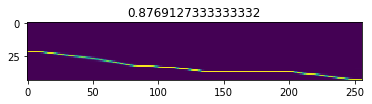

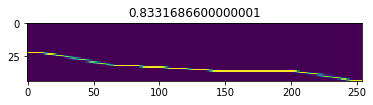

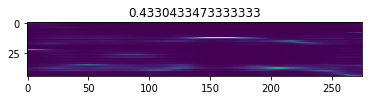

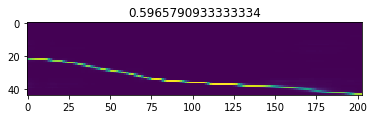

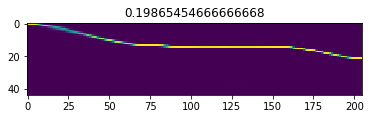

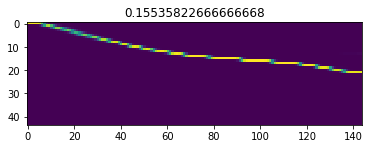

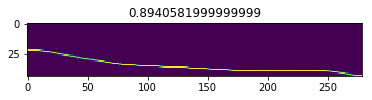

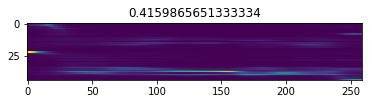

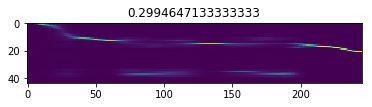

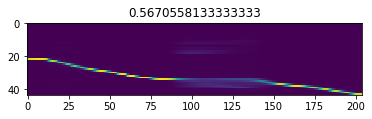

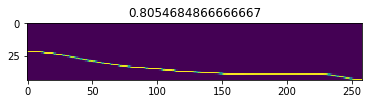

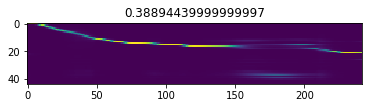

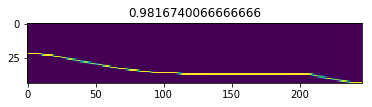

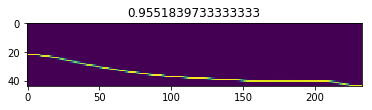

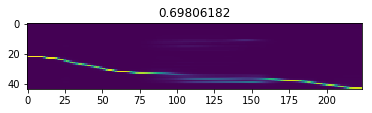

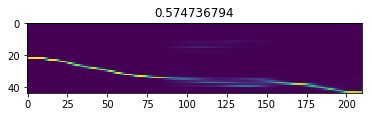

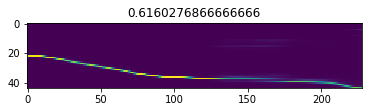

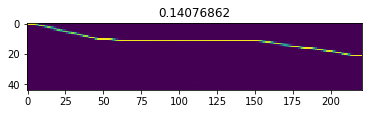

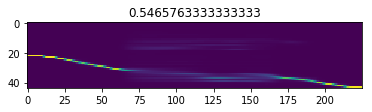

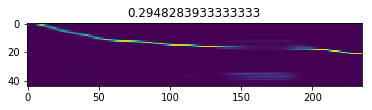

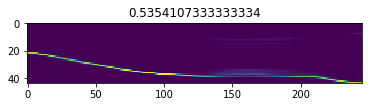

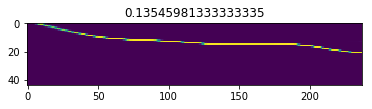

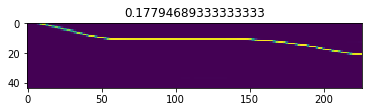

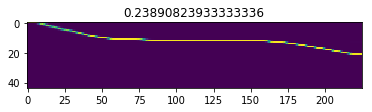

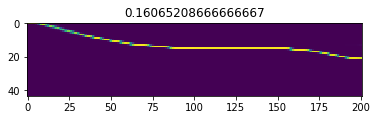

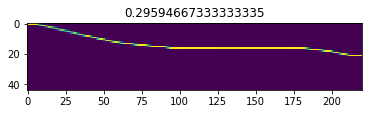

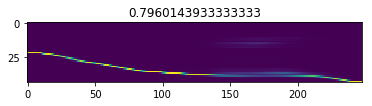

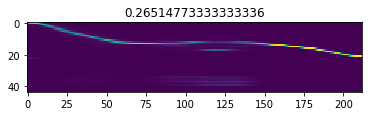

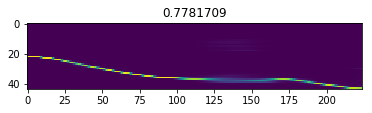

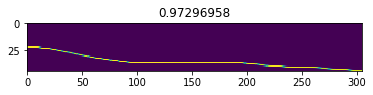

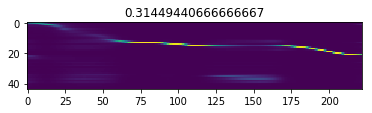

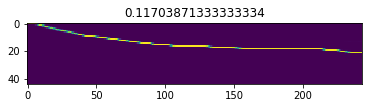

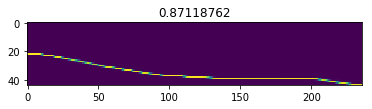

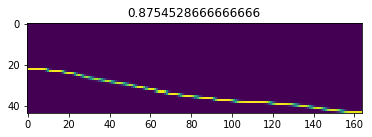

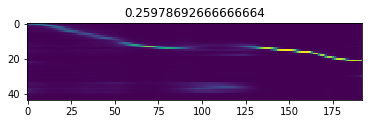

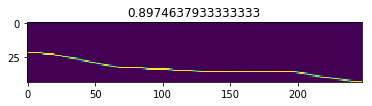

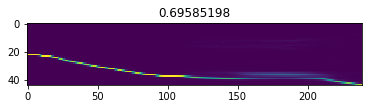

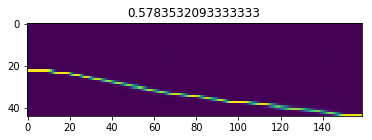

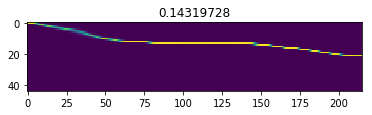

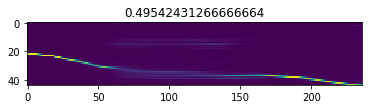

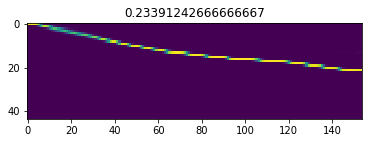

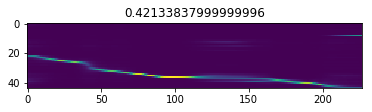

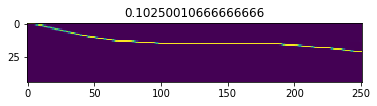

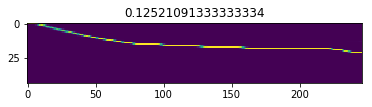

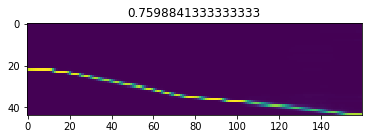

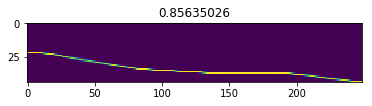

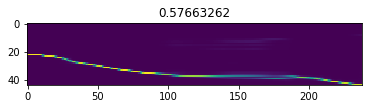

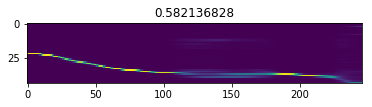

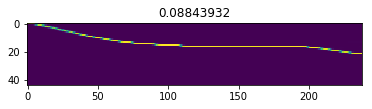

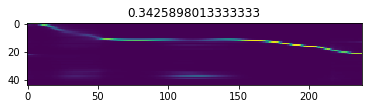

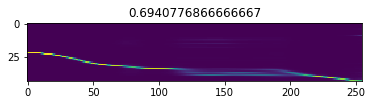

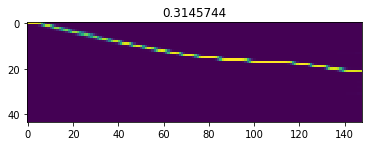

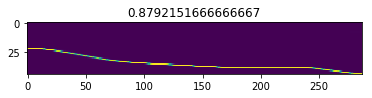

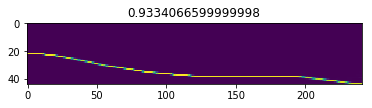

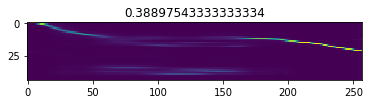

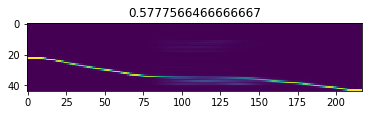

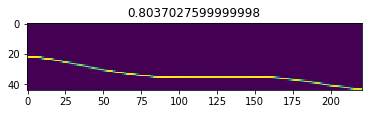

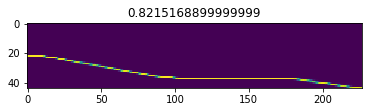

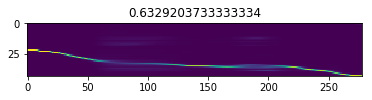

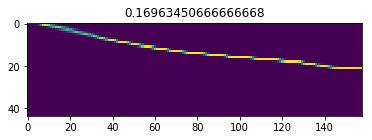

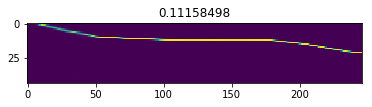

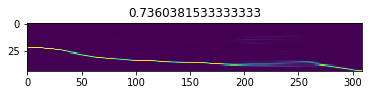

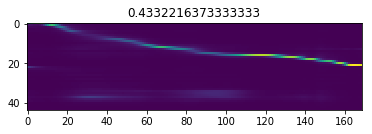

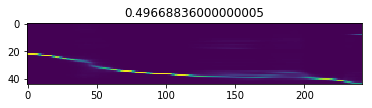

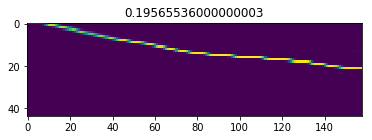

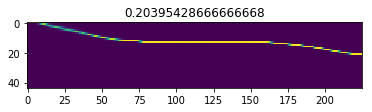

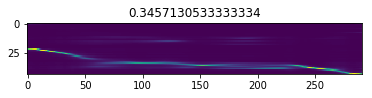

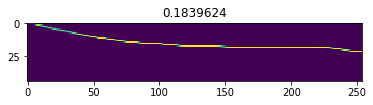

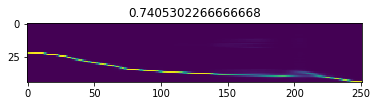

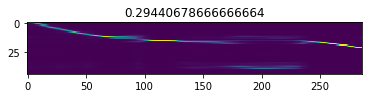

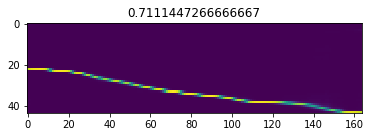

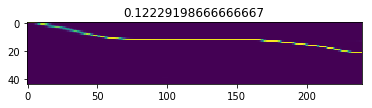

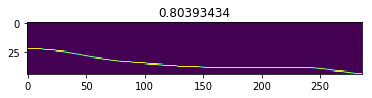

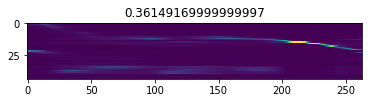

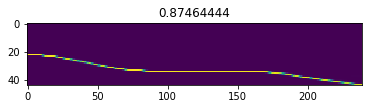

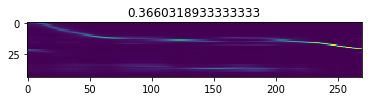

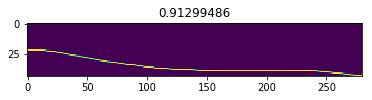

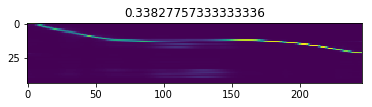

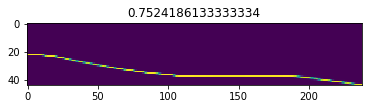

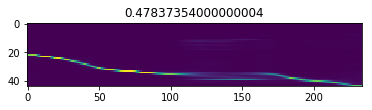

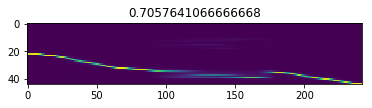

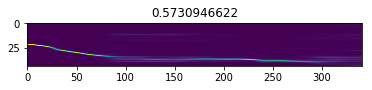

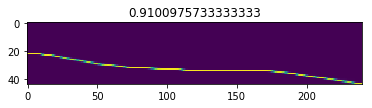

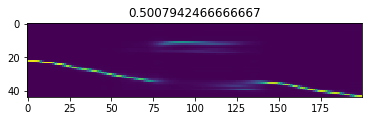

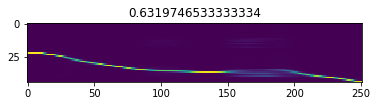

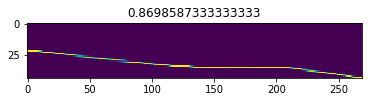

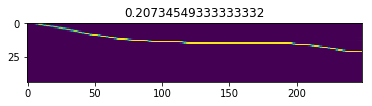

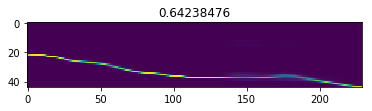

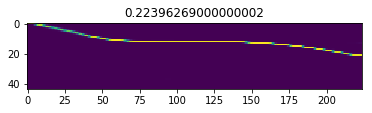

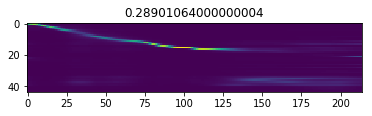

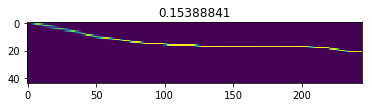

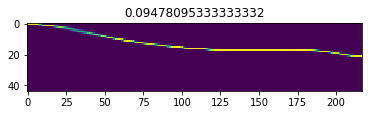

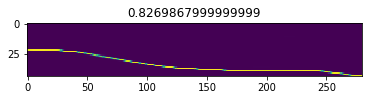

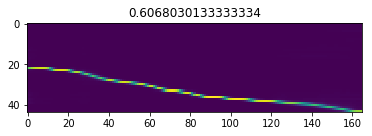

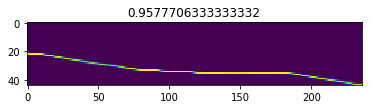

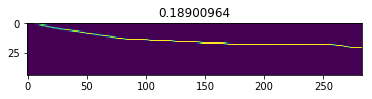

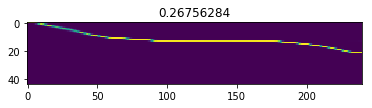

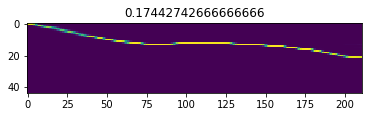

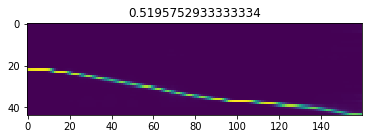

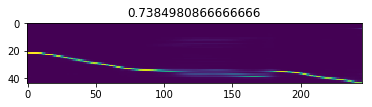

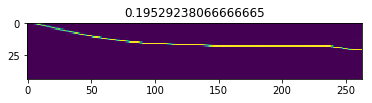

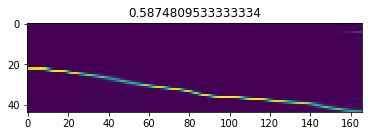

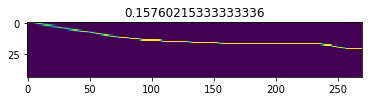

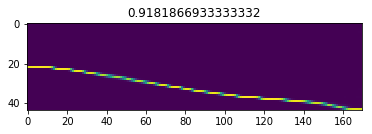

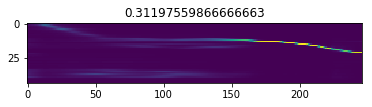

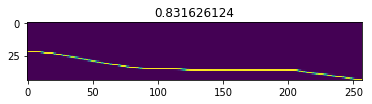

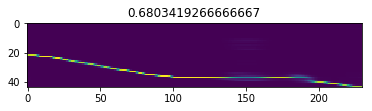

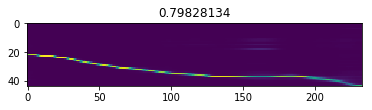

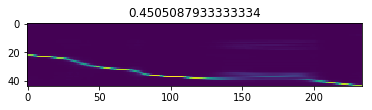

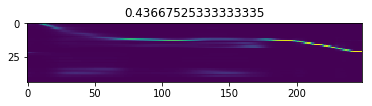

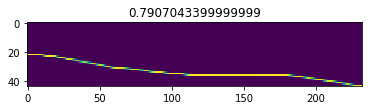

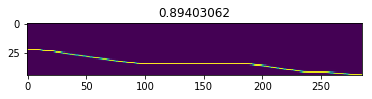

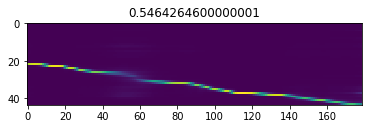

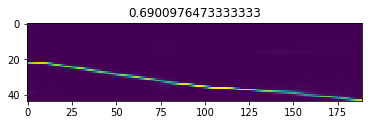

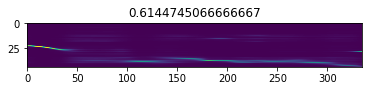

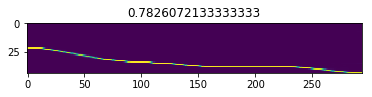

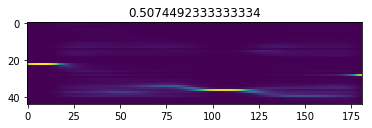

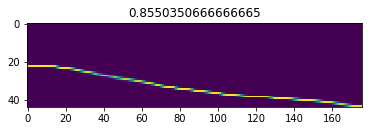

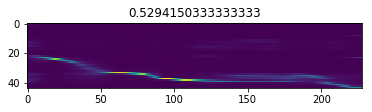

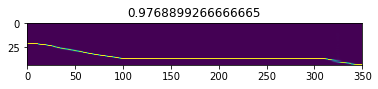

In [119]:
llr = np.zeros([L.shape[0],])
llr_trial = np.zeros([tstart_inds.shape[0],])
print(llr.shape)
for i,(start,stop) in enumerate(zip(tstart_inds.tolist(),teleport_inds.tolist())):
    f,ax = plt.subplots()
    ax.imshow(L[start:stop,:].T)
    ax.set_title(effmorph[i])
    
    tmp=np.log(L[start:stop,:22].sum(axis=1)) - np.log(L[start:stop,22:].sum(axis=1))
    
    llr[start:stop]=tmp
    llr_trial[i]=tmp.mean()

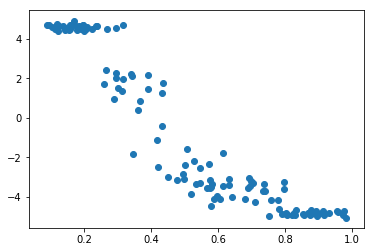

In [120]:
f,ax = plt.subplots()
ax.scatter(effmorph,llr_trial)

In [151]:
logreg = LogisticRegressionCV(Cs=5,penalty='l2',multi_class='multinomial',class_weight="balanced")
# Csm = sp.ndimage.filters.gaussian_filter1d(C,3,axis=0)
# K = C/np.linalg.norm(C,2,axis=1)[:,np.newaxis]
K = sp.stats.zscore(C,axis=1)
logreg.fit(K[train_mask,:],np.digitize(VRDat.pos._values[train_mask],bin_edges)+(bin_edges.shape[0]-1)*VRDat.morph._values[train_mask])
LogL = logreg.predict_proba(K)

C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\mplitt\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


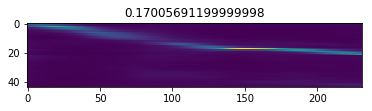

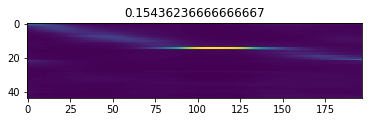

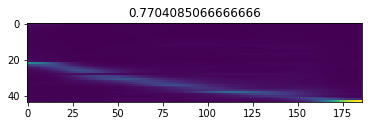

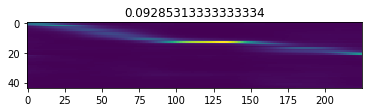

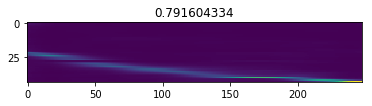

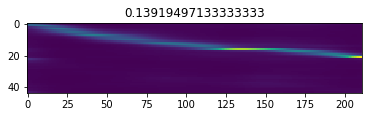

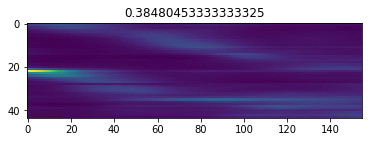

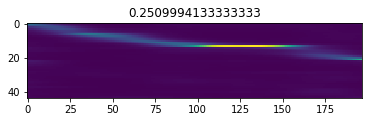

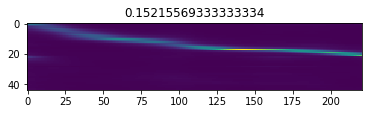

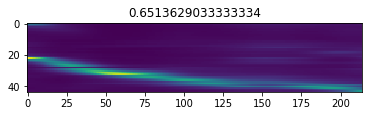

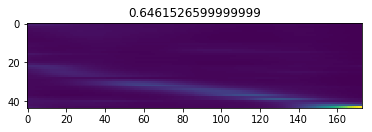

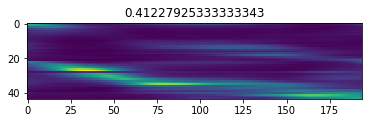

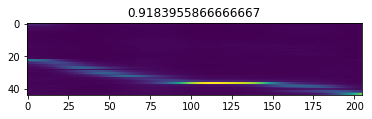

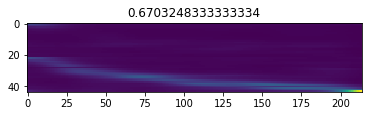

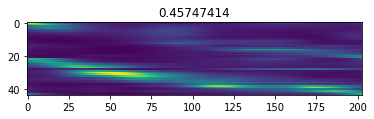

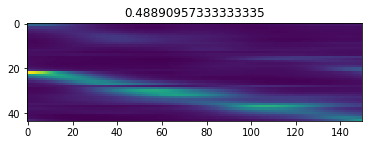

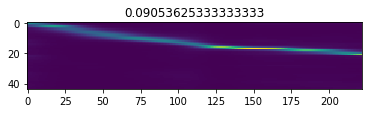

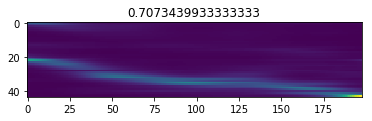

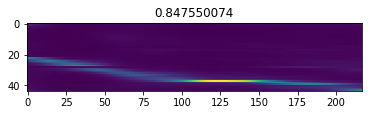

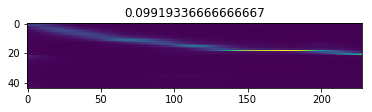

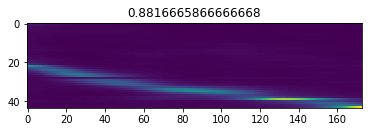

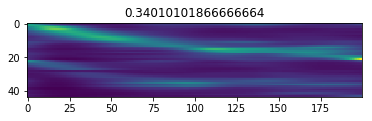

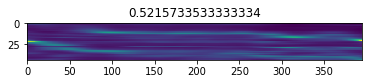

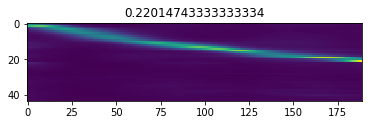

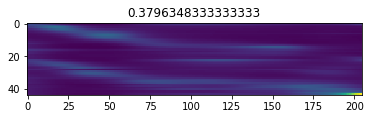

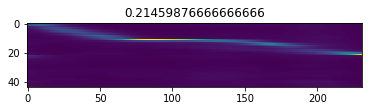

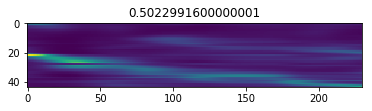

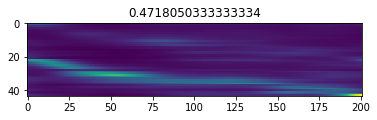

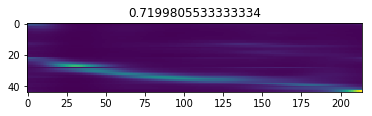

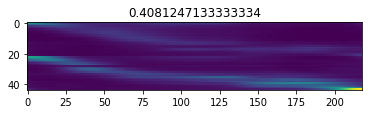

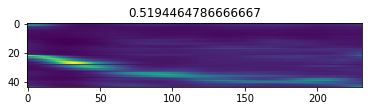

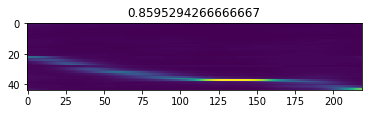

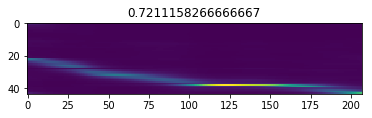

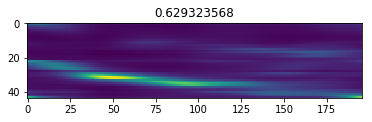

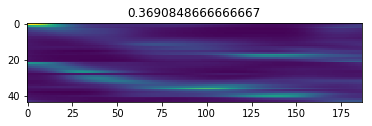

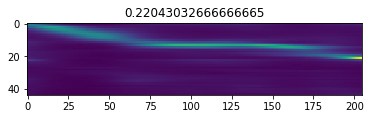

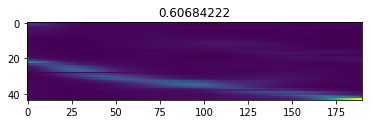

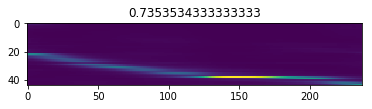

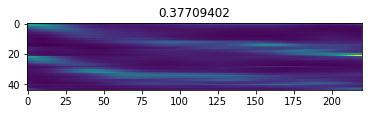

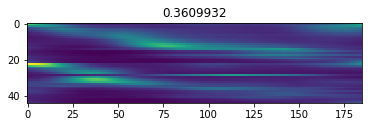

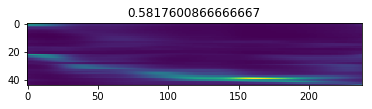

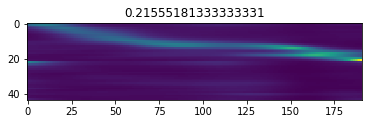

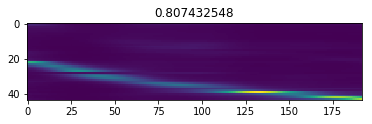

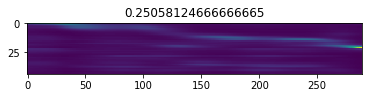

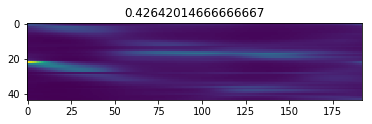

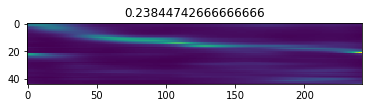

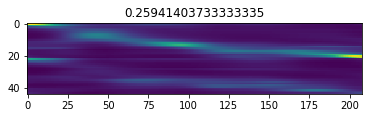

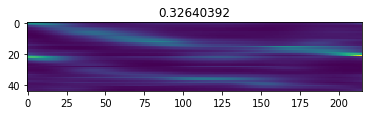

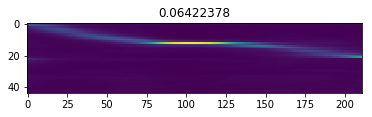

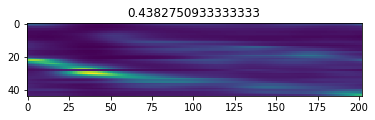

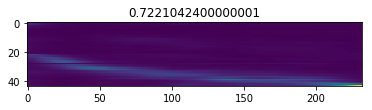

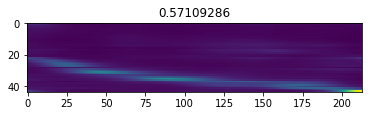

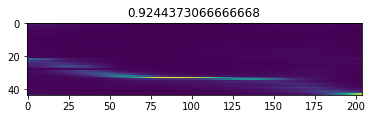

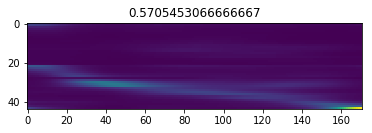

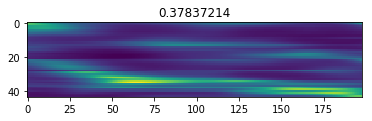

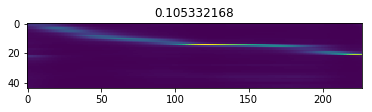

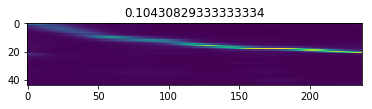

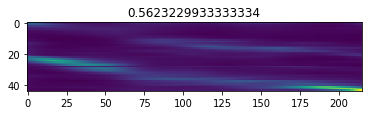

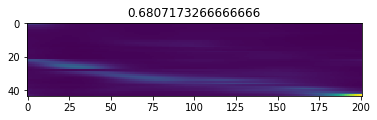

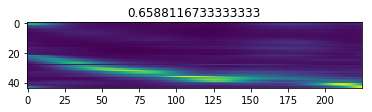

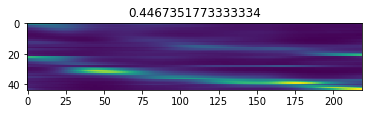

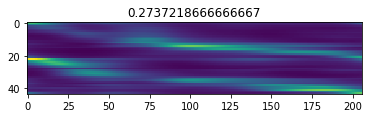

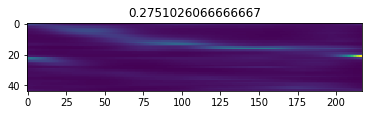

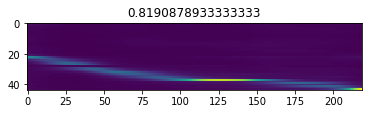

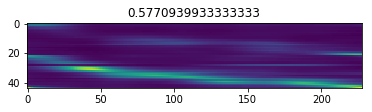

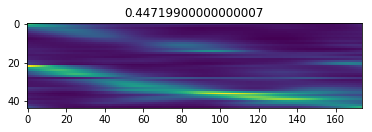

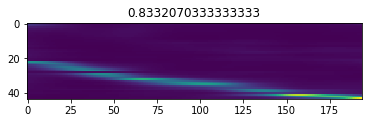

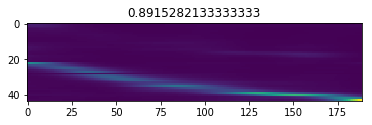

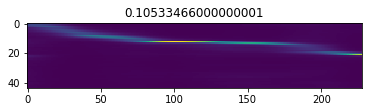

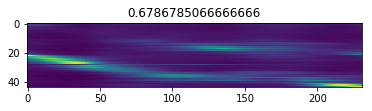

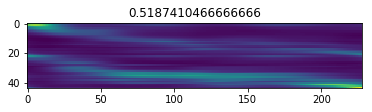

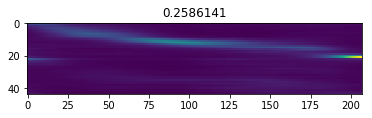

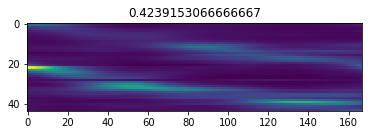

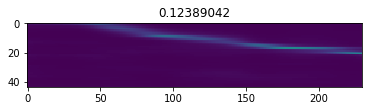

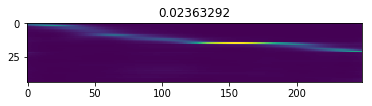

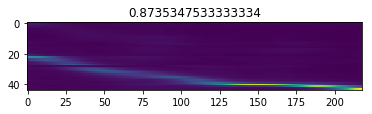

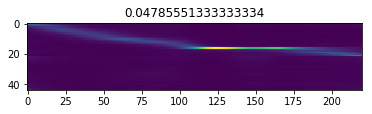

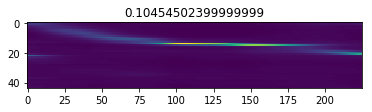

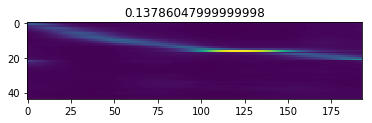

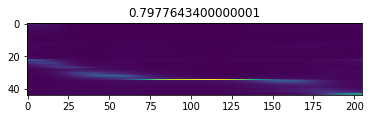

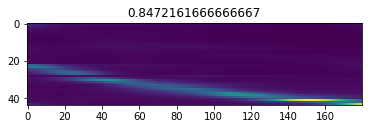

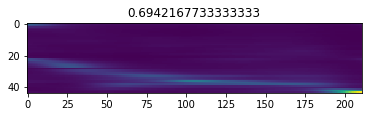

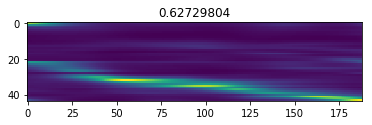

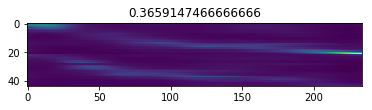

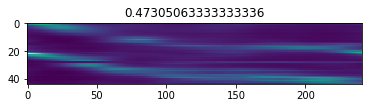

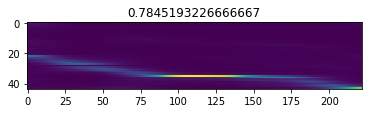

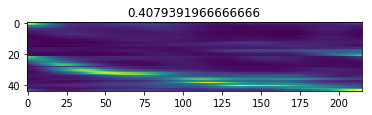

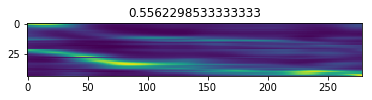

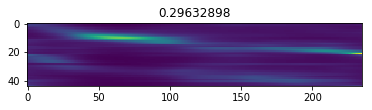

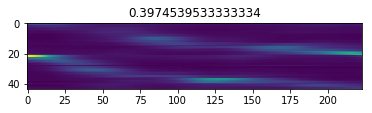

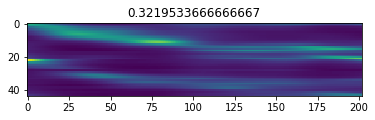

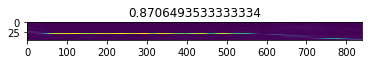

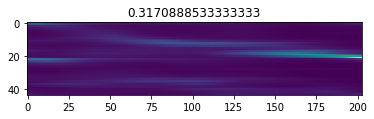

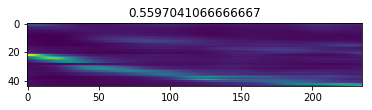

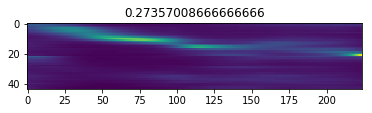

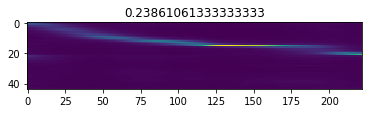

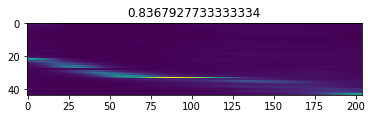

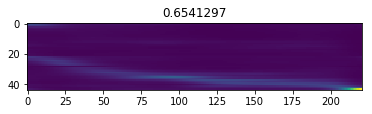

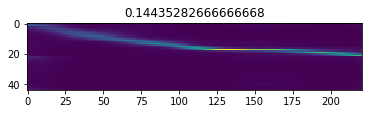

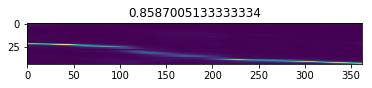

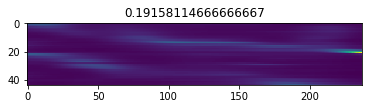

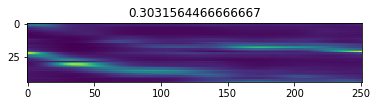

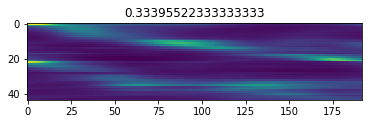

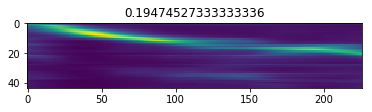

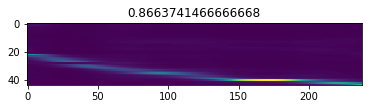

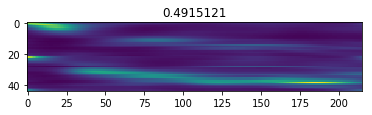

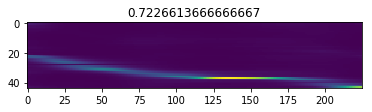

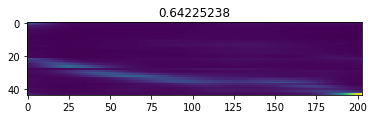

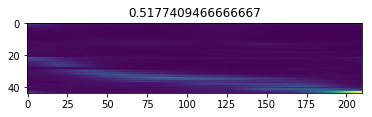

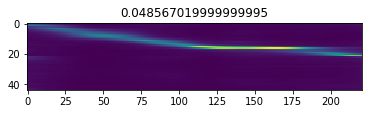

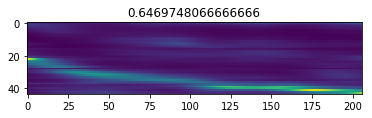

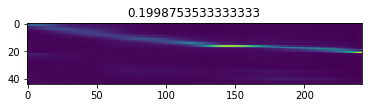

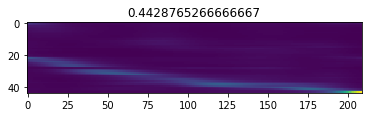

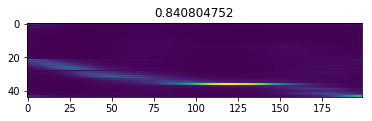

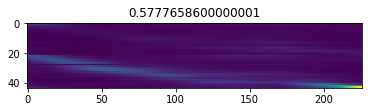

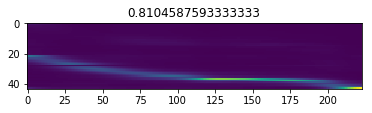

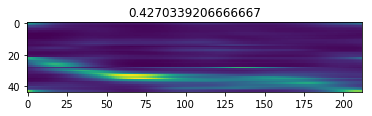

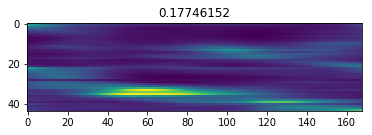

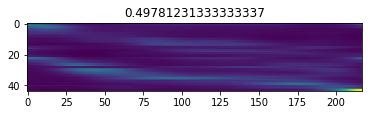

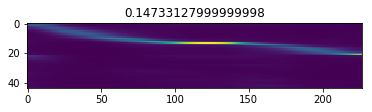

In [154]:
loglr = np.zeros([LogL.shape[0],])
loglr_trial = np.zeros([tstart_inds.shape[0],])

for i,(start,stop) in enumerate(zip(tstart_inds.tolist(),teleport_inds.tolist())):
    f,ax = plt.subplots()
    ax.imshow(LogL[start:stop,:].T)
    ax.set_title(effmorph[i])
    
    tmp=np.log(LogL[start:stop,:22].sum(axis=1)) - np.log(LogL[start:stop,22:].sum(axis=1))
    
    loglr[start:stop]=tmp
    loglr_trial[i]=tmp.mean()

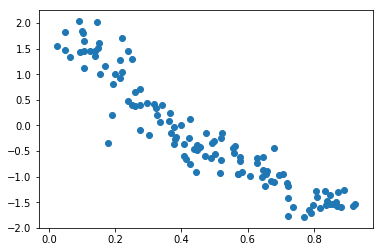

In [155]:
f,ax = plt.subplots()
mask = (trial_info['morphs']==0) | (trial_info['morphs']==1)
ax.scatter(effmorph,loglr_trial)